In [39]:
import mysql.connector
import os
from dotenv import load_dotenv
from mysql.connector import Error

import pandas as pd
import numpy as np

In [4]:
def get_data_from_db(table_name, columns = '*'):
    
    # dot env
    load_dotenv()
    aws_db_ufo_pw = os.getenv('aws_db_ufo_pw')
    aws_host_ufo = os.getenv('aws_host_ufo')

    remote = mysql.connector.connect(
        host = aws_host_ufo,
        user = 'EDA',
        port = 3306,  # default 는 3306
        password = aws_db_ufo_pw,
        database = 'Frisbee'

        )
        
    

    cursor = remote.cursor(dictionary = True)
    
    
    query = f"""
        SELECT {columns} FROM {table_name}"""
    
    cursor.execute(query)
    
    results = cursor.fetchall()
    
    
    column_name = [des[0] for des in cursor.description]
    
    cursor.close()
    
    df = pd.DataFrame.from_records(results, index = column_name[0])
    
    
    return df
    

In [5]:
if __name__ == '__main__':
    df = get_data_from_db('space_weather')
    

In [7]:
df.head()

,date,ap_avg,black_dot_cnt,f107_adj
id,,,,
1,1994-01-01,26.0,126,143.4
2,1994-01-02,21.0,113,141.4
3,1994-01-03,15.0,136,128.7
4,1994-01-04,6.0,151,124.6
5,1994-01-05,4.0,153,132.4


In [8]:
df.tail()

,date,ap_avg,black_dot_cnt,f107_adj
id,,,,
11319,2024-12-27,2.0,257,250.0
11320,2024-12-28,3.0,254,251.8
11321,2024-12-29,4.0,233,246.3
11322,2024-12-30,6.0,218,216.1
11323,2024-12-31,13.0,183,210.4


In [9]:
df.to_csv('/Users/sungminhong/Documents/dev_ws/ufo_eda/data/space_weather_filtered.csv')

In [11]:
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column

In [12]:
df

,date,ap_avg,black_dot_cnt,f107_adj
id,,,,
1,1994-01-01,26.0,126,143.4
2,1994-01-02,21.0,113,141.4
3,1994-01-03,15.0,136,128.7
4,1994-01-04,6.0,151,124.6
5,1994-01-05,4.0,153,132.4
...,...,...,...,...
11319,2024-12-27,2.0,257,250.0
11320,2024-12-28,3.0,254,251.8
11321,2024-12-29,4.0,233,246.3


In [41]:
df['date'] = pd.to_datetime(df['date'])

source = ColumnDataSource(df)

# 산점도용 HoverTool
scatter_hover = HoverTool(
    tooltips=[
        ("Date", "@date{%F}"),
        ("Sunspots (x)", "@black_dot_cnt"),
        ("Solar Flux (y)", "@f107_adj")
    ],
    formatters={'@date': 'datetime'}
)

# 라인 차트용 HoverTool
line_hover = HoverTool(
    tooltips=[
        ("Date", "$x{%F}"), # $x는 x축 값(date)을 의미
        ("Sunspots", "@black_dot_cnt"),
        ("Solar Flux", "@f107_adj")
    ],
    formatters={'$x': 'datetime'},
    mode='vline' # 마우스 커서를 따라 수직선 표시
)

# 산점도 (상관관계 분석)
p1 = figure(
        width=800, 
        height=800,
        title="Sunspot Count vs. Solar Flux (f107_adj) Correlation",
        tools=[scatter_hover, "pan,wheel_zoom,box_zoom,reset,save"]
    )
p1.scatter(
    x='black_dot_cnt', 
    y='f107_adj', 
    source=source, 
    size=5, 
    alpha=0.6,
    color="#0072B2" # Blue
)

p1.xaxis.axis_label = "Sunspot Count (black_dot_cnt)"
p1.yaxis.axis_label = "Adjusted Solar Flux (f107_adj)"


# 1. NaN 값이 있다면 계산에서 제외
cleaned_df = df.dropna(subset=['black_dot_cnt', 'f107_adj'])

# 2. 1차 다항식(선형)으로 피팅 (m = 기울기, b = y절편)
m, b = np.polyfit(cleaned_df['black_dot_cnt'], cleaned_df['f107_adj'], 1)

# 3. 추세선을 그릴 x좌표 생성 (x의 최소값, 최대값)
x_trend = np.array([cleaned_df['black_dot_cnt'].min(), cleaned_df['black_dot_cnt'].max()])

# 4. 추세선의 y좌표 계산 (y = mx + b)
y_trend = m * x_trend + b


# 5. 차트(p1)에 라인 추가
p1.line(
    x=x_trend, 
    y=y_trend, 
    color="red", 
    line_width=3, 
    legend_label="Trend Line"
)

p1.legend.location = "top_left"

# 다중라인 차트 (추세 비교)
p2 = figure(
        width=800, 
        height=400,
        title="Sunspot Count and Solar Flux Over Time",
        x_axis_label='Date',
        x_axis_type='datetime', # x축을 날짜/시간 축으로 설정
        tools=[line_hover, "pan,wheel_zoom,box_zoom,reset,save"]
    )
    
# 흑점 개수 라인
p2.line(
    x='date', 
    y='black_dot_cnt', 
    source=source, 
    line_width=2, 
    color="#0072B2", # Blue
    legend_label="Sunspots (black_dot_cnt)"
)

# 태양 복사 플럭스 라인
p2.line(
    x='date', 
    y='f107_adj', 
    source=source, 
    line_width=2, 
    color="#D55E00", # Red/Orange
    legend_label="Solar Flux (f107_adj)"
)

p2.yaxis.axis_label = "Value"
p2.legend.location = "top_left"
p2.legend.click_policy = "hide" # 범례 클릭 시 해당 라인 숨기기

# 두 차트를 수직(column)으로 배열
layout = column(p1, p2)

output_file = '/Users/sungminhong/Documents/dev_ws/ufo_eda/data/plot/space_weather_bokeh.html'


# HTML 파일로 저장
save(layout, filename=output_file, title="Sunspot and Solar Flux Analysis")

print(f"성공: Bokeh 차트를 '{output_file}' 파일로 저장했습니다.")
print("이 HTML 파일을 웹 브라우저에서 열어 확인하세요.")



성공: Bokeh 차트를 '/Users/sungminhong/Documents/dev_ws/ufo_eda/data/plot/space_weather_bokeh.html' 파일로 저장했습니다.
이 HTML 파일을 웹 브라우저에서 열어 확인하세요.


/var/folders/kh/6khx28zs2bq8wjptklpbkj440000gn/T/ipykernel_44658/1755852394.py:113: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(layout, filename=output_file, title="Sunspot and Solar Flux Analysis")


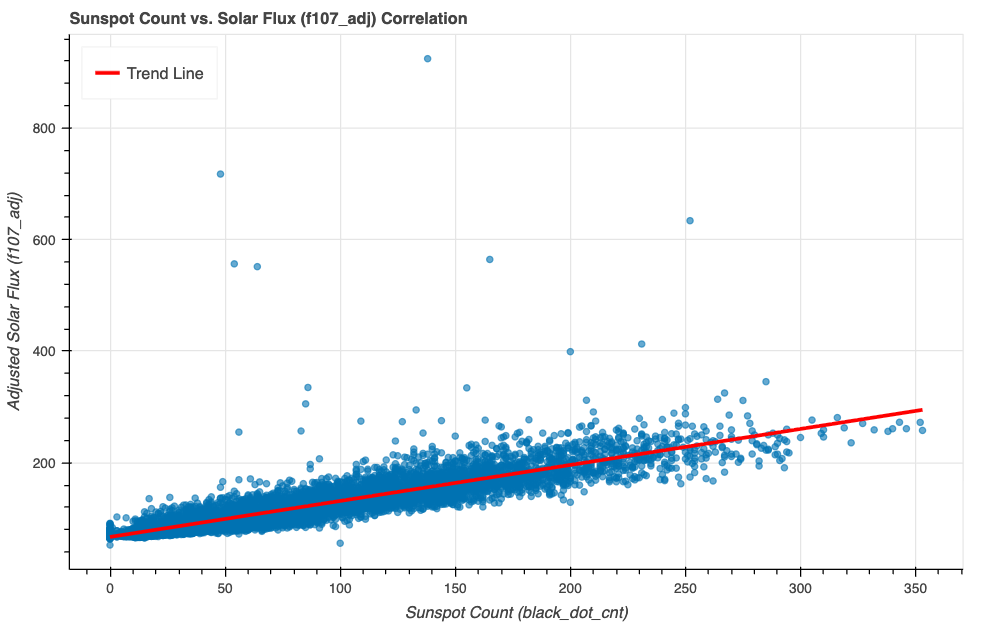

1. 방향 : 우상향으로 양의 상관관계
2. 강도 : 점들이 추세선 주변에 빽빽하게 모여 있음
3. outliers : 추세선 위쪽으로 있는 점은 흑점 개수에 비해 태양 복사 플럭스가 유난히 강했던 날을 의미 아래에 있는 점은 흑점이 많았음에도 복사 플럭스는 낮았던날을 의미

아웃라이어가 발생한 날짜들이 특별한 활동이 있었는지 추가로 조사해볼 가치가 있음

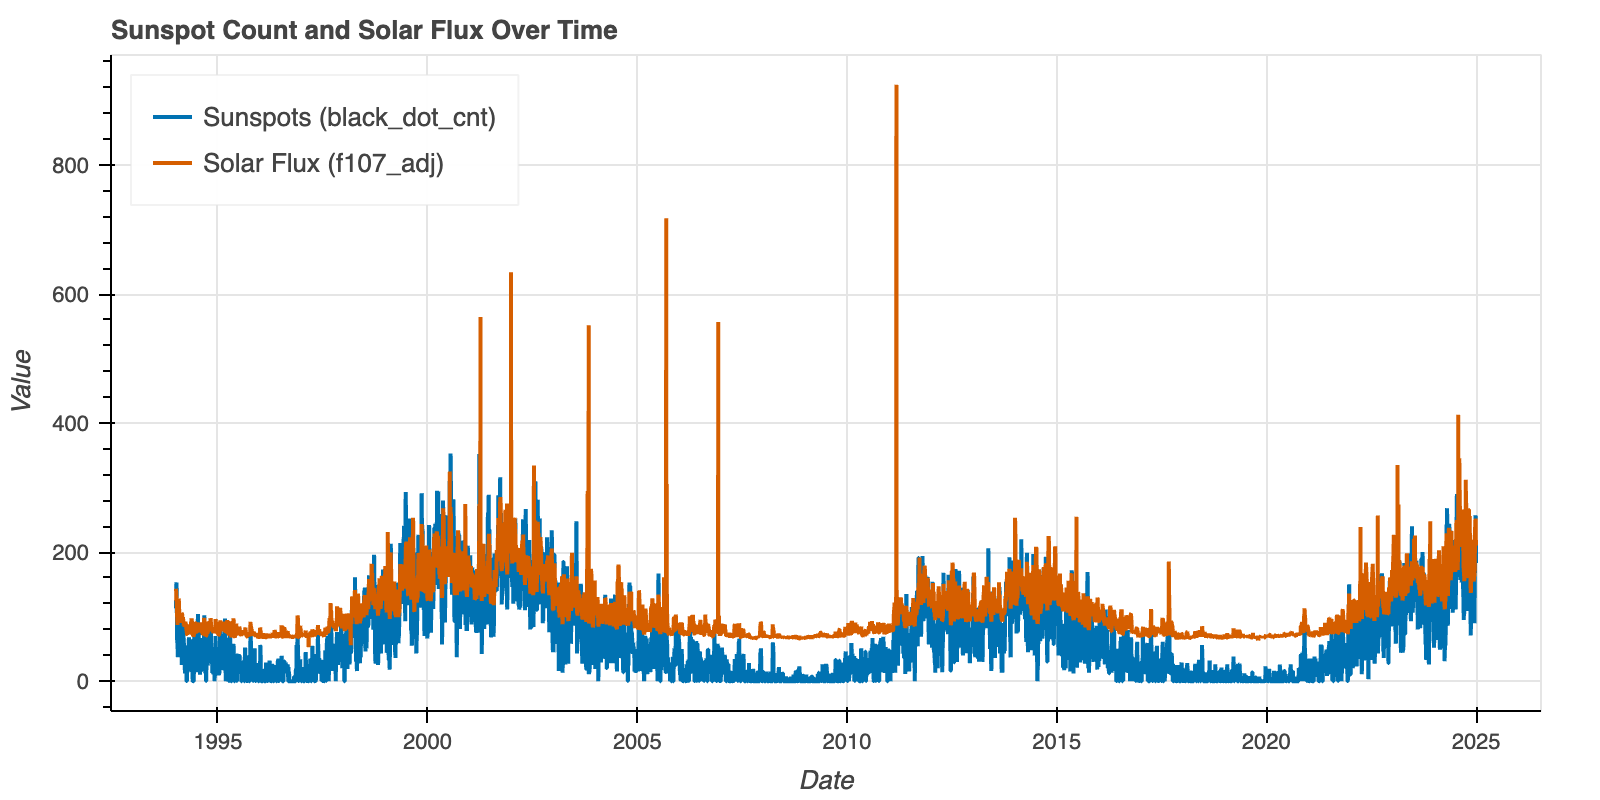

태양 흑점 갯수와 플럭스 수치를 비교 했을때 플럭스 수치가 급격히 높아지는 구간이 있음 이 구간의 날짜와 ufo의 출현일과 비교 하여 플럭스 수치가 UFO의 관찰과의 관계를 확인 필요

In [44]:
df['date'] = pd.to_datetime(df['date'])

source = ColumnDataSource(df)

# 산점도용 HoverTool
scatter_hover = HoverTool(
    tooltips=[
        ("Date", "@date{%F}"),
        ("Sunspots (x)", "@black_dot_cnt"),
        ("average Ap index", "@ap_avg")
    ],
    formatters={'@date': 'datetime'}
)

# 라인 차트용 HoverTool
line_hover = HoverTool(
    tooltips=[
        ("Date", "$x{%F}"), # $x는 x축 값(date)을 의미
        ("Sunspots", "@black_dot_cnt"),
        ("average Ap index", "@ap_avg")
    ],
    formatters={'$x': 'datetime'},
    mode='vline' # 마우스 커서를 따라 수직선 표시
)

# 산점도 (상관관계 분석)
p1 = figure(
        width=800, 
        height=500,
        title="Sunspot Count vs. average Ap index(ap_avg) Correlation",
        tools=[scatter_hover, "pan,wheel_zoom,box_zoom,reset,save"]
    )
p1.scatter(
    x='black_dot_cnt', 
    y='ap_avg', 
    source=source, 
    size=5, 
    alpha=0.6,
    color="#6FDC9A" 
)

p1.xaxis.axis_label = "Sunspot Count (black_dot_cnt)"
p1.yaxis.axis_label = "average Ap index (ap_avg)"


# 1. NaN 값이 있다면 계산에서 제외
cleaned_df = df.dropna(subset=['black_dot_cnt', 'ap_avg'])

# 2. 1차 다항식(선형)으로 피팅 (m = 기울기, b = y절편)
m, b = np.polyfit(cleaned_df['black_dot_cnt'], cleaned_df['ap_avg'], 1)

# 3. 추세선을 그릴 x좌표 생성 (x의 최소값, 최대값)
x_trend = np.array([cleaned_df['black_dot_cnt'].min(), cleaned_df['black_dot_cnt'].max()])

# 4. 추세선의 y좌표 계산 (y = mx + b)
y_trend = m * x_trend + b


# 5. 차트(p1)에 라인 추가
p1.line(
    x=x_trend, 
    y=y_trend, 
    color="#765083", 
    line_width=3, 
    legend_label="Trend Line"
)

p1.legend.location = "top_left"



# 다중라인 차트 (추세 비교)
p2 = figure(
        width=800, 
        height=400,
        title="Sunspot Count and average Ap index",
        x_axis_label='Date',
        x_axis_type='datetime', # x축을 날짜/시간 축으로 설정
        tools=[line_hover, "pan,wheel_zoom,box_zoom,reset,save"]
    )
    
# 흑점 개수 라인
p2.line(
    x='date', 
    y='black_dot_cnt', 
    source=source, 
    line_width=2, 
    color="#0072B2", # Blue
    legend_label="Sunspots (black_dot_cnt)"
)

# 태양 복사 플럭스 라인
p2.line(
    x='date', 
    y='ap_avg', 
    source=source, 
    line_width=2, 
    color="#66D48D", # Red/Orange
    legend_label="average Ap index(ap_avg)"
)

p2.yaxis.axis_label = "Value"
p2.legend.location = "top_left"
p2.legend.click_policy = "hide" # 범례 클릭 시 해당 라인 숨기기

# 두 차트를 수직(column)으로 배열
layout = column(p1, p2)

output_file = '/Users/sungminhong/Documents/dev_ws/ufo_eda/data/plot/space_weather_bokeh_2.html'


# HTML 파일로 저장
save(layout, filename=output_file, title="average Ap index")

print(f"성공: Bokeh 차트를 '{output_file}' 파일로 저장했습니다.")
print("이 HTML 파일을 웹 브라우저에서 열어 확인하세요.")



성공: Bokeh 차트를 '/Users/sungminhong/Documents/dev_ws/ufo_eda/data/plot/space_weather_bokeh_2.html' 파일로 저장했습니다.
이 HTML 파일을 웹 브라우저에서 열어 확인하세요.


/var/folders/kh/6khx28zs2bq8wjptklpbkj440000gn/T/ipykernel_44658/10717261.py:113: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(layout, filename=output_file, title="average Ap index")


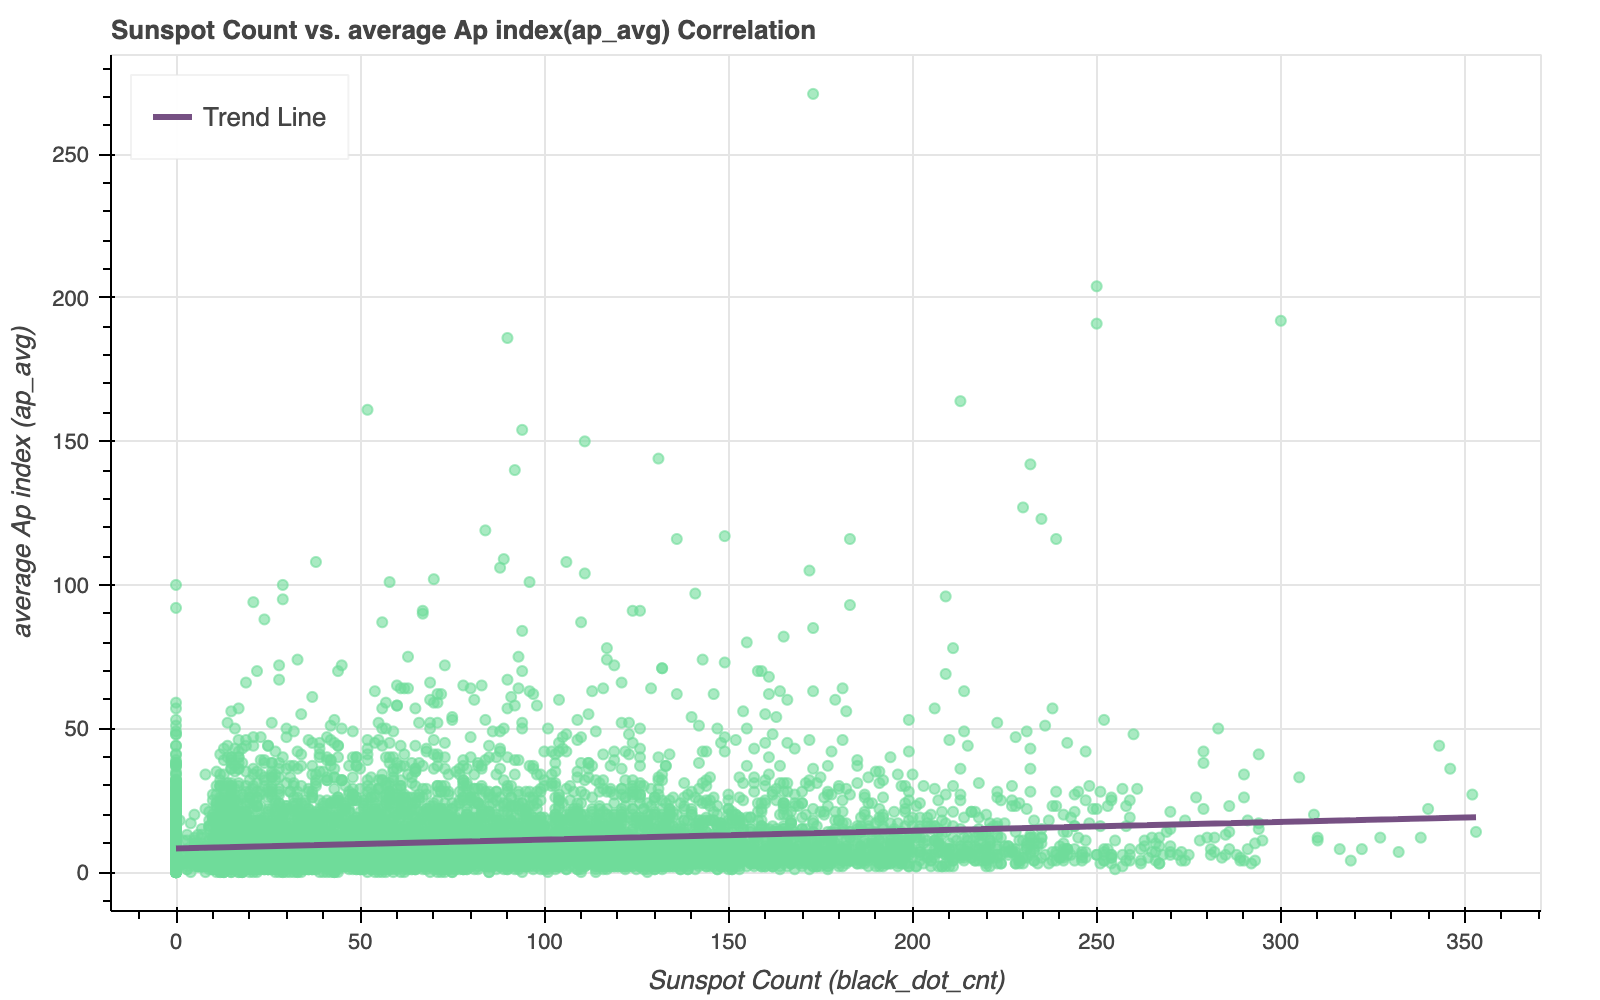
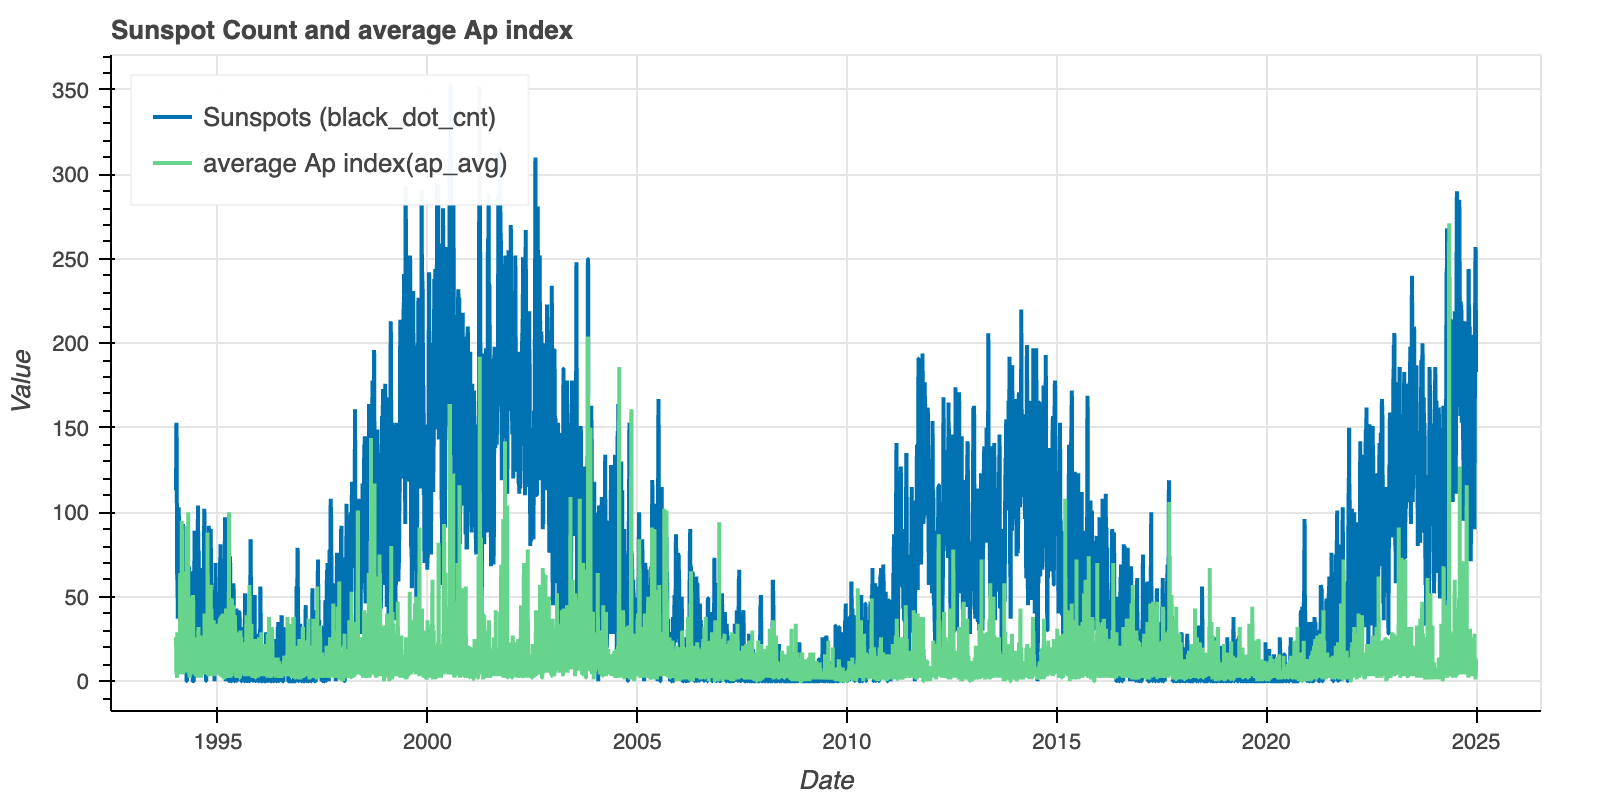